<h1>Experiments with Gaussian + Linear fits to spectra</h1>

Fitters tested in this notebook:

- astropy.modeling.fitting
  - Levenberg-Marquardt
  - Simplex
  - SLSQP
- scipy.optimize.curve_fit
- ODRPACK
- lmfit

In older_notebooks/experiment_fiting.ipynb:

- saba (Sherpa)
  - Levenberg-Marquardt
  - Moncar
  - Nelder-Mead
  
  Note that Sherpa requires python 2.7. Since specviz can only run under python 3.5 or later (for now at least), we didn't explore Saba in its full potential yet.  

In [1]:
from __future__ import print_function

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
# constants for all plots
x_label = '$\lambda$($\mu$)'
y_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
plot_axis = [0.8, 2.4, 2.8e-15, 4.e-15]

<h3>Get raw data</h3>

This is the same dataset shown in github issue #145. 

In [2]:
data = np.genfromtxt("data/example_spec_ipac.txt")
wave = data[:,0]
flux = data[:,1]

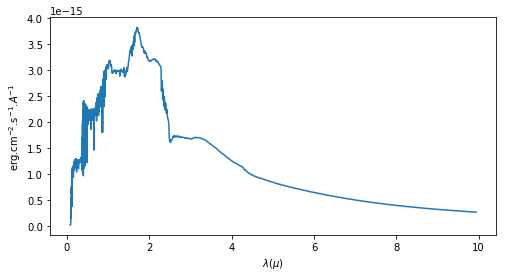

In [3]:
plt.gcf().set_size_inches(8.,4.)
plt.plot(wave, flux)
plt.xlabel(x_label)
plt.ylabel(y_label)

<h3>Extract regions of interest </h3>

Here we extract two ROIs: 
 - the exact same ROI displayed in issue #145 (1.09$\mu$ < wavelength < 2.25$\mu$)
 - a slightly wider ROI (0.9$\mu$ < wavelength < 2.35$\mu$) that includes some contamination at the edges to test the fitter's sensitivity to ROI selection.

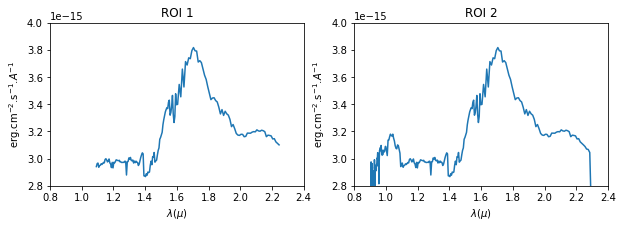

In [4]:
indices = (wave > 1.09) & (wave < 2.25) 
w1 = wave[indices]
f1 = flux[indices]
indices = (wave > 0.9) & (wave < 2.35) 
w2 = wave[indices]
f2 = flux[indices]

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("ROI 2")

<h3>Build compound models</h3>

For each ROI, we build two Gaussian+linear models. Each one is initialized in a different way:
 - we separately and independently initialize the Gaussian and linear components based on the data. This is what specviz does.
 - we simultaneously compute all the 5 initialization parameters (3 for the Gaussian, 2 for the linear) based on the data.
 
A third model applicaple on any ROI uses whatever default initialization is provided by the tested library (thus disregarding the data).

In [5]:
from astropy.modeling import models

def initialize_gaussian(w, f):
    centroid = np.sum(w * f) / np.sum(f)

    dw = w - np.mean(w)
    fwhm = 2 * np.sqrt(np.sum((dw * dw) * f) / np.sum(f))
    sigma = fwhm / 2.355

    delta_w = w[1:] - w[:-1]
    sum_f = np.sum((f[1:] - np.min(f[1:])) * delta_w)
    height = sum_f / (sigma * np.sqrt( 2 * np.pi))
    
    return height, centroid, sigma

def initialize_linear(w, f):
    # compute averages at the 5% of data at each extreme of the wavelength range.
    l = int(len(w) / 20)
    w1 = np.mean(w[0:l])
    w2 = np.mean(w[-l-1:-1])
    f1 = np.mean(f[0:l])
    f2 = np.mean(f[-l-1:-1])
    # fit a straigth line thru these 
    slope = (f2 - f1) / (w2 - w1)
    inter = f2 - slope * w2
    return slope, inter

def initialize_compound(w, f):
    slope, inter = initialize_linear(w, f)
    fc = f - (w * slope + inter)
    height, centroid, sigma = initialize_gaussian(w, fc)
    return height, centroid, sigma, slope, inter
    
# independent Gaussian and linear initializations - ROIs 1 and 2
h, c, s = initialize_gaussian(w1, f1)
gaussian_s_1 = models.Gaussian1D(amplitude=h, mean=c, stddev=s)
s, i = initialize_linear(w1, f1)
linear_s_1 = models.Linear1D(slope=s, intercept=i)
model_s_1 = gaussian_s_1 + linear_s_1

h, c, s = initialize_gaussian(w2, f2)
gaussian_s_2 = models.Gaussian1D(amplitude=h, mean=c, stddev=s)
s, i = initialize_linear(w2, f2)
linear_s_2 = models.Linear1D(slope=s, intercept=i)
model_s_2 = gaussian_s_2 + linear_s_2

# Gaussian + linear initialized all at once - ROIs 1 and 2
height, centroid, sigma, slope, inter = initialize_compound(w1, f1)
gaussian_c_1 = models.Gaussian1D(amplitude=height, mean=centroid, stddev=sigma)
linear_c_1 = models.Linear1D(slope=slope, intercept=inter)
model_c_1 = gaussian_c_1 + linear_c_1
p1 = [height, centroid, sigma, slope, inter]

height, centroid, sigma, slope, inter = initialize_compound(w2, f2)
gaussian_c_2 = models.Gaussian1D(amplitude=height, mean=centroid, stddev=sigma)
linear_c_2 = models.Linear1D(slope=slope, intercept=inter)
model_c_2 = gaussian_c_2 + linear_c_2
p2 = [height, centroid, sigma, slope, inter]

# Default initialization
model_d = models.Gaussian1D() + models.Linear1D()

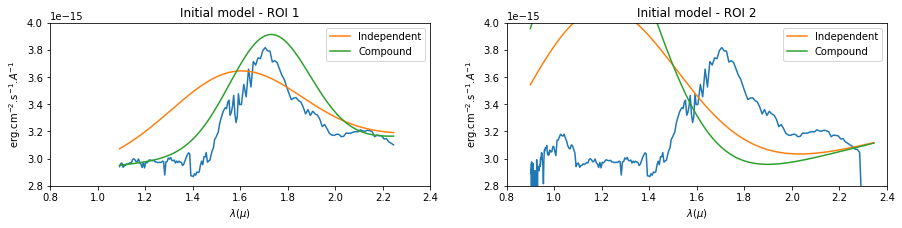

In [6]:
plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, model_s_1(w1), label='Independent')
plt.plot(w1, model_c_1(w1), label='Compound')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Initial model - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, model_s_2(w2), label='Independent')
plt.plot(w2, model_c_2(w2), label='Compound')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Initial model - ROI 2")

The default iitialization is not plotted because it is way off scale.

<h3>Fit using astropy</h3>

ZZZZZZZZZZ   L-M:   Model: CompoundModel2
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=8.4893772148465285e-16, mean=1.724396717076304, stddev=0.16961080238193388)>

    [1]: <Linear1D(slope=1.8041923499311953e-16, intercept=2.753000072977637e-15)>
Parameters:
      amplitude_0        mean_0    ...      slope_1         intercept_1   
    ---------------- ------------- ... ----------------- -----------------
    6.7287532235e-16 1.70782649514 ... 2.34157589345e-16 2.66893872008e-15


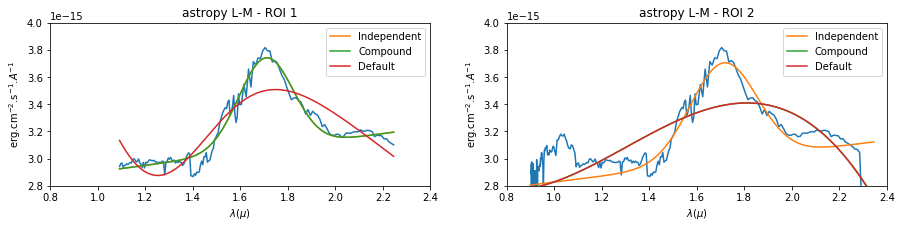

In [7]:
from astropy.modeling import fitting

# L-M

lm_fitter = fitting.LevMarLSQFitter()
maxi = 2000

lm_fm_s_1 = lm_fitter(model_s_1, w1, f1, maxiter=maxi)
lm_fm_s_2 = lm_fitter(model_s_2, w2, f2, maxiter=maxi)
lm_fm_c_1 = lm_fitter(model_c_1, w1, f1, maxiter=maxi)
lm_fm_c_2 = lm_fitter(model_c_2, w2, f2, maxiter=maxi)
lm_fm_d_1 = lm_fitter(model_d, w1, f1, maxiter=maxi)
lm_fm_d_2 = lm_fitter(model_d, w2, f2, maxiter=maxi)


print("ZZZZZZZZZZ   L-M:  ", lm_fm_c_1)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, lm_fm_s_1(w1), label='Independent')
plt.plot(w1, lm_fm_c_1(w1), label='Compound')
plt.plot(w1, lm_fm_d_1(w1), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("astropy L-M - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, lm_fm_s_2(w2), label='Independent')
plt.plot(w2, lm_fm_c_2(w2), label='Compound')
plt.plot(w2, lm_fm_d_2(w2), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("astropy L-M - ROI 2")

In [8]:
print(lm_fitter.fit_info['message'])

Number of calls to function has reached maxfev = 2000.


The compound and independent initializations above, in each ROI, give identical results. The default initialization runs out of iterations. I tried up to 20,000 iterations and got the same solutions and same warning every time.

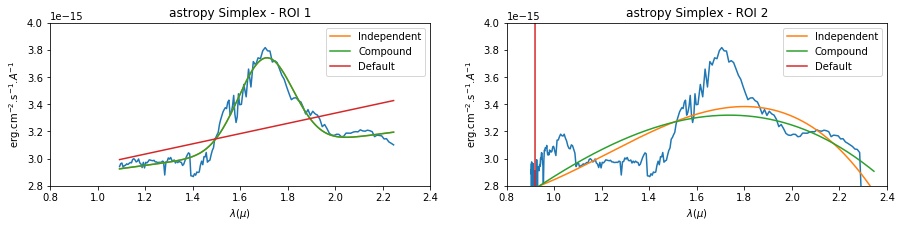

In [9]:
# Simplex

simplex_fitter = fitting.SimplexLSQFitter()
maxi = 2000

simplex_fm_s_1 = simplex_fitter(model_s_1, w1, f1, maxiter=maxi)
simplex_fm_s_2 = simplex_fitter(model_s_2, w2, f2, maxiter=maxi)
simplex_fm_c_1 = simplex_fitter(model_c_1, w1, f1, maxiter=maxi)
simplex_fm_c_2 = simplex_fitter(model_c_2, w2, f2, maxiter=maxi)
simplex_fm_d_1 = simplex_fitter(model_d, w1, f1, maxiter=maxi)
simplex_fm_d_2 = simplex_fitter(model_d, w2, f2, maxiter=maxi)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, simplex_fm_s_1(w1), label='Independent')
plt.plot(w1, simplex_fm_c_1(w1), label='Compound')
plt.plot(w1, simplex_fm_d_1(w1), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("astropy Simplex - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, simplex_fm_s_2(w2), label='Independent')
plt.plot(w2, simplex_fm_c_2(w2), label='Compound')
plt.plot(w2, simplex_fm_d_2(w2), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("astropy Simplex - ROI 2")

As in the L-M case, the compound and independent initializations gave identical results in ROI 1. 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.52520660177477e-29
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.368959989593038e-28
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.046578224205755e-30
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.149381660920577e-28
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.239590692459936e-07
            Iterations: 24
            Funct

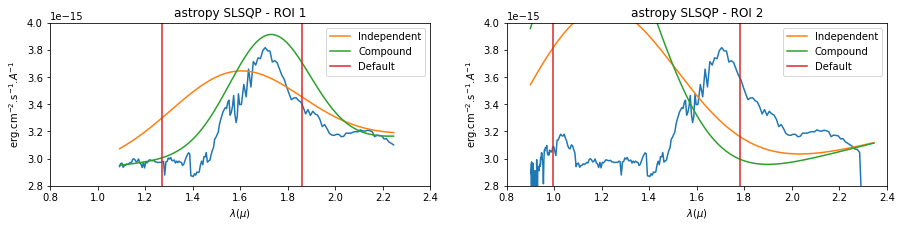

In [10]:
# SLSQP

slsqp_fitter = fitting.SLSQPLSQFitter()
maxi = 2000

slsqp_fm_s_1 = slsqp_fitter(model_s_1, w1, f1, maxiter=maxi)
slsqp_fm_s_2 = slsqp_fitter(model_s_2, w2, f2, maxiter=maxi)
slsqp_fm_c_1 = slsqp_fitter(model_c_1, w1, f1, maxiter=maxi)
slsqp_fm_c_2 = slsqp_fitter(model_c_2, w2, f2, maxiter=maxi)
slsqp_fm_d_1 = slsqp_fitter(model_d, w1, f1, maxiter=maxi)
slsqp_fm_d_2 = slsqp_fitter(model_d, w2, f2, maxiter=maxi)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, slsqp_fm_s_1(w1), label='Independent')
plt.plot(w1, slsqp_fm_c_1(w1), label='Compound')
plt.plot(w1, slsqp_fm_d_1(w1), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("astropy SLSQP - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, slsqp_fm_s_2(w2), label='Independent')
plt.plot(w2, slsqp_fm_c_2(w2), label='Compound')
plt.plot(w2, slsqp_fm_d_2(w2), label='Default')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("astropy SLSQP - ROI 2")

<h3>Repeat with optimize.curve_fit fitter </h3>

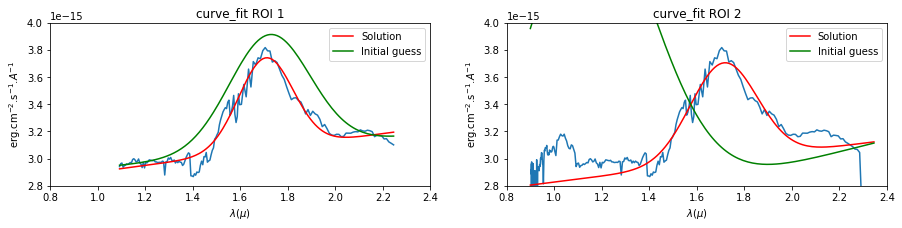

In [12]:
from scipy.optimize import curve_fit

def func(x, a, x0, sigma, slope, intercept):
    return (models.Gaussian1D(amplitude=a, mean=x0, stddev=sigma) + \
            models.Linear1D(slope=slope, intercept=intercept))(x)

# Calling 'curve_fit' with initial guesses for the parameters does not work 
# regardless of the combination of first guesses and  methods used.
# 
# These calls either raise an exception when reaching maxfev, or just skip
# everything and return the first guesses as the answer. 
#
# Note that method 'lm' basically calls the same 'leastsq' function used by 
# astropy's L-M fitter. It can't deal with bounds though; for that, method 
# 'trf' would be required.

# popt1, pcov1 = curve_fit(func, w1, f1, p0=p1, method='lm', maxfev=10000)
# popt2, pcov2 = curve_fit(func, w2, f2, p0=p2, method='lm', maxfev=10000)

# Not providing first guesses or method: this will runs the 'lm' method and
# uses default first guesses. Surprisingly (for ROI 2), it seems to work.
popt1, pcov1 = curve_fit(func, w1, f1)
popt2, pcov2 = curve_fit(func, w2, f2)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, func(w1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4]), color='red', label='Solution')
plt.plot(w1, func(w1, p1[0], p1[1], p1[2], p1[3], p1[4]), color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("curve_fit ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, func(w2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]), color='red', label='Solution')
plt.plot(w2, func(w2, p2[0], p2[1], p2[2], p2[3], p2[4]), color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("curve_fit ROI 2")

Note that, in this case, curve_fit did work correctly without initialization. Further testing suggested that this could be a fluke though. In general, it will need sensible initial guesses for the parameters.

curve_fit runs the 'lm' method by default. However, 'lm' won't support bounded model parameters. For that, one can use curve_fit with the 'method' argument set to either 'trf' (Trust Region Reflective) or 'dogbox' (rectangular trust regions, aka dogleg).Both support bounded parameters.

Called in this way, curve_fit acts effectively as a wrapped around the 'optimize.least_squares' function. Next, we run this optimizer over the test data.

8 [  6.43487300e-16   1.71843563e+00   1.28950671e-01   2.38568051e-16
   2.64923433e-15]
2 [  5.00000000e-16   1.70000000e+00   2.64752951e-01   2.50000000e-16
   2.54262685e-15]


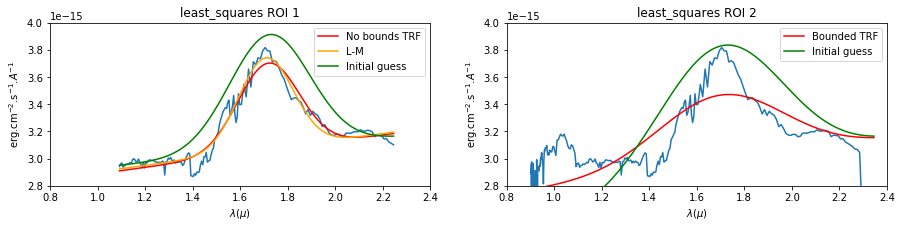

In [13]:
# 'scipy.optimize.least_squares' gives access to three different 
# optimizers: 'lm', 'trf', and 'dogbox'. With 'lm' it defaults to
# calling 'leastsq'. Any benefit provided by including 'least_squares'
# in specviz would come then from its ability to run the 'trf' and
# 'dogbox' algorithms. 
# 
# Both 'trf' and 'dogbox' are the only algorithms in scipy capable of
# handling bounds. These might be of interest in the future; here, we 
# run some experiments with bounds. Note that, to add 'least_squares'
# to specviz's code, it should be re-cast into the astropy Fitter meta
# class framework, and implement code that handles constraints and ties 
# (a non-trivial task, likely.
# 
# 'least_squares' provides a rich set of input parameters to control 
# and monitor the fitting process. These abilities are probably beyond 
# the scope of specviz.

from scipy.optimize import least_squares

def func_res(p, x, y):
    return (models.Gaussian1D(amplitude=p[0], mean=p[1], stddev=p[2]) + \
            models.Linear1D(slope=p[3], intercept=p[4]))(x) - y

p2[1] = 1.7 # force it to be close to the peak
p2[0] = 1.e-15

res_lsq_1 = least_squares(func_res, np.array(p1), args=(w1, f1), gtol=1.E-15, xtol=1.E-15, ftol=1.E-15) 
res_lsq_1_lm = least_squares(func_res, np.array(p1), method='lm', args=(w1, f1), gtol=1.E-15, xtol=1.E-15, ftol=1.E-15) 
res_lsq_2 = least_squares(func_res, np.array(p2), args=(w2, f2), \
                          bounds=([0.0,    1.5,  0.0,  0.0,   -np.inf],\
                                  [1.e-15, 1.9,  0.5,  5.e-16, np.inf]), gtol=1.E-15, xtol=1.E-15, ftol=1.E-15) 
s1 = res_lsq_1['x']
s1_lm = res_lsq_1_lm['x']
s2 = res_lsq_2['x']

print(res_lsq_1['nfev'], s1)
print(res_lsq_2['nfev'], s2)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, func(w1, s1[0], s1[1], s1[2], s1[3], s1[4]), color='red', label='No bounds TRF')
plt.plot(w1, func(w1, s1_lm[0], s1_lm[1], s1_lm[2], s1_lm[3], s1_lm[4]), color='orange', label='L-M')
plt.plot(w1, func(w1, p1[0], p1[1], p1[2], p1[3], p1[4]), color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("least_squares ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, func(w2, s2[0], s2[1], s2[2], s2[3], s2[4]), color='red', label='Bounded TRF')
plt.plot(w2, func(w2, p2[0], p2[1], p2[2], p2[3], p2[4]), color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("least_squares ROI 2")

<h3>Repeat with Model from lmfit </h3>

In [14]:
from lmfit import Model

def gaussian(x, amp, cen, wid):
    return models.Gaussian1D(amplitude=amp, mean=cen, stddev=wid)(x)

def linear(x, slope, inter):
    return models.Linear1D(slope=slope, intercept=inter)(x)

# lmfit doesn't support parameter default values. Initialize with specviz values.

# independent Gaussian and linear initializations - ROIs 1 and 2
mod_s_1 = Model(gaussian) + Model(linear)
h, c, sigma = initialize_gaussian(w1, f1)
slope, i = initialize_linear(w1, f1)
pars_s_1 = mod_s_1.make_params(amp=h, cen=c, wid=sigma, slope=slope, inter=i)
lmfit_fm_s_1 = mod_s_1.fit(f1, pars_s_1, x=w1)

mod_s_2 = Model(gaussian) + Model(linear)
h, c, sigma = initialize_gaussian(w2, f2)
slope, i = initialize_linear(w2, f2)
pars_s_2 = mod_s_2.make_params(amp=h, cen=c, wid=sigma, slope=slope, inter=i)
lmfit_fm_s_2 = mod_s_2.fit(f2, pars_s_2, x=w2)

# Gaussian + linear initialized all at once - ROIs 1 and 2
mod_c_1 = Model(gaussian) + Model(linear)
h, c, sigma, slope, i = initialize_compound(w1, f1)
pars_c_1 = mod_c_1.make_params(amp=h, cen=c, wid=sigma, slope=slope, inter=i)
lmfit_fm_c_1 = mod_c_1.fit(f1, pars_c_1, x=w1)

mod_c_2 = Model(gaussian) + Model(linear)
h, c, sigma, slope, i = initialize_compound(w2, f2)
pars_c_2 = mod_c_2.make_params(amp=h, cen=c, wid=sigma, slope=slope, inter=i)
lmfit_fm_c_2 = mod_c_2.fit(f2, pars_c_2, x=w2)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, lmfit_fm_s_1.best_fit, label='Independent')
plt.plot(w1, lmfit_fm_c_1.best_fit, label='Compound')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("lmfit - ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, lmfit_fm_s_2.best_fit, label='Independent')
plt.plot(w2, lmfit_fm_c_2.best_fit, label='Compound')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("lmfit - ROI 2")

ImportError: No module named 'lmfit'

### Repeat with ODRPACK

Orthogonal Distance Regression is designed to handle the case where errors are present in both the independent and dependent variables. This is probably not the most common use case in spectroscopy in the UV-IR band, so there might be not much of a point in adding this to specviz. ODRPACK uses a modified trust-region L-M optimizer. According to the original paper, it falls back into ordinary L-M (as in optimize.leastsq) when errors in wavelength are to be ignored. Although it's not clear that the particular implementation of ODRPACK can be more efficient than MINPACK's L-M (optimize.leastsq). Like astropy's fitters, it supports constrained (fixed) parameters, but no bounded parameters.

This is the example straight from https://github.com/tiagopereira/python_tips/wiki/Scipy:-curve-fitting

In [ ]:
# This notebook cell contains the exact same code as in the doc page above.
#
# Note that the Gaussian as defned in here is not the same as the Gaussian
# defined in astropy's Gaussian1D model. The code we use elsewhere in this 
# script to compute first guesses for the Gaussian parameters is based on 
# astropy's Gaussian formulation though. This may lead to somewhat different 
# first guesses when mixing together both representations.

import math
from scipy.odr import odrpack as odr
from scipy.odr import models

def gaussian(B,x):
    ''' Returns the gaussian function for B=m,stdev,max,offset '''
    return B[3]+B[2]/(B[1]*math.sqrt(2*math.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))

def gauss_lsq(x,y,verbose=False,itmax=200,iparams=[]):
    ''' Performs a gaussian least squares fit to the data,
    with errors! Uses scipy odrpack, but for least squares.'''

    def _gauss_fjd(B,x):
        # Analytical derivative of gaussian with respect to x
        return 2*(x-B[0])*gaussian(B,x)

    def _gauss_fjb(B,x):
        # Analytical derivatives of gaussian with respect to parameters
        _ret = np.concatenate(( -2*(x-B[0])*gaussian(B,x),\
                             ((x-B[0])**2/(2*B[1]**2)-1)/B[1]*gaussian(B,x),\
                             gaussian(B,x)/B[2] ,\
                             np.ones(x.shape, float) ))
        _ret.shape = (4,) + x.shape
        return _ret
    
    # Center data in mean(x) (makes better conditioned matrix)
    mx = np.mean(x)
    x2 = x - mx
    
    if not any(iparams):
        # automatic guessing of gaussian's initial parameters (saves iterations)
        iparams = np.array([x2[np.argmax(y)],np.std(y),math.sqrt(2*math.pi)*np.std(y)*np.max(y),1.])
        
        print("iparams: ", iparams)

    gauss  = odr.Model(gaussian, fjacd=_gauss_fjd, fjacb=_gauss_fjb)
    mydata = odr.Data(x2, y)
    myodr  = odr.ODR(mydata, gauss, beta0=iparams, maxit=itmax)

    # Set type of fit to least-squares:
    myodr.set_job(fit_type=2)
    if verbose == 2: myodr.set_iprint(final=2)
            
    fit = myodr.run()
    
    # Display results:
    if verbose:
        fit.pprint()
        print('Re-centered Beta: [%f  %f  %f %f]' % \
              (fit.beta[0]+mx,fit.beta[1],fit.beta[2],fit.beta[3]))

    itlim = False
    if fit.stopreason[0] == 'Iteration limit reached':
        itlim = True
        print('(WWW) gauss_lsq: Iteration limit reached, result not reliable!')

    # Results and errors
    coeff = fit.beta
    coeff[0] += mx # Recentre in original axis
    err   = fit.sd_beta

    return coeff,err,itlim

The example above assumes a constant baseline, and our data has a slant baseline. So we first subtract the baseline, then fit, then add back the baseline previously subtracted. Note that this may introduce correlated errors in case we use this procedure to compute errors for the function parameters. The correct way to treat the slanted baseline would be to modify the functional form above to include the linear first-order term.

In [ ]:
# get first guess estimates
h1, c1, s1, slope1, inter1 = initialize_compound(w1, f1)
h2, c2, s2, slope2, inter2 = initialize_compound(w2, f2)

# subtract baseline from the data
f1_0 = f1 - (slope1 * w1 + inter1)
f2_0 = f2 - (slope2 * w2 + inter2)

# The example code above requires that the gaussian center 
# position be defined wrt the wavelength mean.
c1 -= np.mean(w1)
c2 -= np.mean(w2)

# initial estimates. Offset is zero by construction.
iparams1 = [c1, s1, h1, 0.0]
iparams2 = [c2, s2, h2, 0.0]

# iparams = [0.1, 0.13, 1.5e-16, 0.0]

In experimenting with this script, we find that first guesses are necessary to achieve any meaningful result.

In [ ]:
# fit
fit1, errors, itlim = gauss_lsq(w1, f1_0, verbose=True,itmax=5000, iparams=iparams1)
print("Result for ROI 1: ", fit1)
print("Errors: ", errors)
print(itlim)

fit2, errors, itlim = gauss_lsq(w2, f2_0, verbose=True,itmax=5000, iparams=iparams2)
print("Result for ROI 2: ", fit2)
print("Errors: ", errors)
print(itlim)

In [ ]:
# add slanted baselines back to solution
f1_fit = gaussian(fit1, w1) + (slope1 * w1 + inter1)
f2_fit = gaussian(fit2, w2) + (slope2 * w2 + inter2)

In [ ]:
# plot results

# to plot the first guess, we put back the wavelength mean.
iparams1[0] += np.mean(w1)
iparams2[0] += np.mean(w2)
f1_init = gaussian(iparams1, w1) + (slope1 * w1 + inter1)
f2_init = gaussian(iparams2, w2) + (slope2 * w2 + inter2)

# first guess values derived in this way are not the same as 
# first guesses derived elsewhere using astropy's Gaussian 
# formuation, as per explanation in cell [14]

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, f1_fit, color='red', label='Fit')
plt.plot(w1, f1_init, color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("ODR ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, f2_fit, color='red', label='Fit')
plt.plot(w2, f2_init, color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("ODR ROI 2")

# Summary


|Fitter             | Initialization    |    ROI 1             |     ROI 2           | 
|:------------------|:------------------|:---------------------|:--------------------|
| astropy L-M       | independent       | FIT WORKS            | FIT WORKS           |
| astropy L-M       | compound          | FIT WORKS            | FIT WORKS           |
| astropy L-M       | default           | moves closer         | moves closer        |
|                   |                   |                      |                     |
| astropy Simplex   | independent       | FIT WORKS            | moves closer        |
| astropy Simplex   | compound          | FIT WORKS            | moves closer        |
| astropy Simplex   | default           | Gaussian disappears  | Gaussian disappears |
|                   |                   |                      |                     |
| astropy SLSQP(\*) | independent       | does nothing         | does nothing        |
| astropy SLSQP     | compound          | does nothing         | does nothing        |
| astropy SLSQP     | default           | diverges             | diverges            |
|                   |                   |                      |                     |
| scipy curve_fit   | default           | FIT WORKS            | FIT WORKS           |
| scipy curve_fit   | compound          | never converges      | never converges     |
|                   |                   |                      |                     |
| least_squares TRF | compound, unbound | FIT WORKS            | not tested          |
| least_squares TRF | compound, bounded | moves closer         | moves closer        |
|                   |                   |                      |                     |
| lmfit             | independent       | FIT WORKS            | FIT WORKS           |
| lmfit             | compound          | FIT WORKS            | doesn't work        |
|                   |                   |                      |                     |
| odr               | compound          | FIT WORKS            | doesn't work        |

(\*) SLSQP requires the data to be normalized to ~1.


# Maybe worthwhile to look into

- http://central.scipy.org/item/28/2/fitting-a-gaussian-to-noisy-data-points 

  - Looked into this. I don't quite get the author's point. From the code viewpoint, it looks like the algorithm has to do with fitting a Gaussian by fitting an (approximatley) equivalent parabola to the log of the data. This won't solve our problem with negative sigmas and z's (see experiment_redshift.ipynb notebook). In any case, the code (specifically, the fit_direct function) can't be used in the context of compound models since the model in this case is implicit and set to be one single, isolated Gaussian. The code is just a call to np.linalg.lstsq, I don't see how it's going to help us in any way different than astropy already does. 

- http://www.adamgginsburg.com/pygaussfit.htm